In [1]:
%matplotlib inline

In [2]:
import cv2
from utils.imageprocessing import *
from sklearn.cluster import KMeans

In [3]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

In [4]:
def Extract_background_mask(image):
    # convert RGB 2 Gray
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_floodFill = image_gray.copy()

    # make mask
    h, w = image_gray.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # floodFill
    cv2.floodFill(img_floodFill, mask, (0,0), 0, flags = cv2.FLOODFILL_MASK_ONLY)

    mask = mask[1:-1, 1:-1]
    plt.grid(False)
    plt.imshow(mask, cmap="gray") 
    plt.show()
    return mask

In [5]:
def Extract_color(image, k = 3):
    # make background mask
    mask = Extract_background_mask(image)
    
    # 색상 클러스터링
    flat_image = image.reshape(image.shape[0] * image.shape[1], 3)
    flat_mask = mask.reshape(image.shape[0] * image.shape[1])
    
    idx = np.where(flat_mask != 1)
    flat_image = flat_image[idx[0]]
    
    clt = KMeans(n_clusters = k)
    clt.fit(flat_image)

    hist = centroid_histogram(clt)
    color = clt.cluster_centers_
    
    # sort hist and color by descending hist
    sort_idx= np.argsort(hist)[::-1]
    hist_sort = [hist[idx] for idx in sort_idx]
    color_sort = [color[idx] for idx in sort_idx]
    
    # draw color bar
    bar = plot_colors(hist_sort, color_sort)
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    
    return hist_sort, color_sort

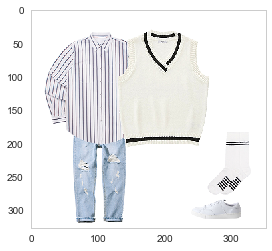

In [6]:
image_path = "1.jpeg"

#preview image
image = cv2.imread(image_path)  

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, None, fx=1/4, fy=1/4, interpolation = cv2.INTER_CUBIC)
plt.grid(False)
plt.imshow(image)
plt.show()

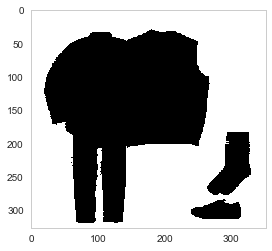

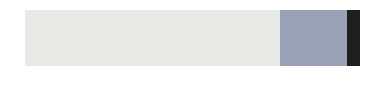

In [7]:
hist, color = Extract_color(image, 3)
bar = plot_colors(hist, color)